In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd

# Introduction

In late 2020 I listened to an episode of RadioLab called "Breaking Benford" (https://www.wnycstudios.org/podcasts/radiolab/articles/breaking-benford) that introduced me to the Benford distribution. At about the same time in my graduate physics class, we were discussing Monte Carlo simulations and how they can be used to obtain accurate estimations of irrational numbers such as pi and Euler's number. This confluence of ideas immediately set me to thinking that it should also be possible to use such repeat random sampling techniques to accurately generate the Benford distribution.

### What is the Benford distribution?

First formally characterized by Frank Benford in 1938, the later named "Benford" distribution describes the distribution of the first digits of numbers [1-9] in some datasets, particularly datasets wherein the numbers are spread out over several orders of magnitude. The Benford distribution is shown below. With numbers in a dataset that adheres to the Benford distribution, we see that 30.1% of the numbers start with the digit 1, 17.6% start with the digit 2, etc... all the way down to only 4.5% of the numbers starting with a 9. 

In [3]:
def showBenford(x):
    trueBenford = [0.30103, 0.17609, 0.12491, 0.09692, 0.07918, 0.06696, 0.05799, 0.05116, 0.04576]
    xticks = np.arange(1,10,1)
    plt.figure(figsize=(9,6))
    plt.bar(xticks,x,label = "Experimental Distribution")
    plt.bar(xticks,trueBenford,alpha = 0.5,color='red',label = "Benford Distribution")
    plt.title("Benford Distribution",size=20)
    plt.xticks(ticks = xticks, size=16,labels = xticks)
    plt.xlabel("First Digit",size=20)
    plt.yticks(size=16)
    plt.ylabel("Density",size=20)
    plt.legend(fontsize=16)
    plt.show()

### Figure 1

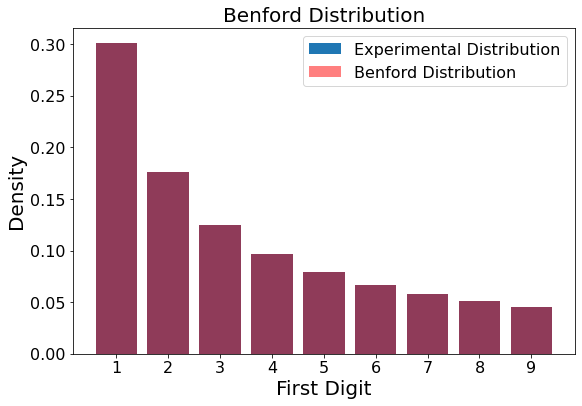

In [5]:
Benford = np.array([0.30103, 0.17609, 0.12491, 0.09692, 0.07918, 0.06696, 0.05799, 0.05116, 0.04576])
showBenford(Benford)

### Simulating the Benford distribution

In [4]:
def simulateBenford(samples, oom, ulresets):
    highLimit = 10**oom                             # Set the order of magnitude 
    results = np.zeros(samples)                     # Create numpy array for results
    for i in range(0, samples):                     # Collect a sample n times
        randomInt = sampler(highLimit, ulresets)    # Pass size of dataset and # of randomizations to sampler function
        results[i] = str(randomInt)[0]      # Place first digit of sample into the results array
    results=np.bincount(results.astype('int64'),minlength=10)[1:]/samples # Freq. of each digit & normalize to unity
    return results                          # Return results, an array of length 9 with each digits density

def sampler(upperLimit, resets):   
    upperLim = np.random.randint(1, high=upperLimit) # Perform one reset of the upper limit
    resets -=1                                       # Decrement randomizations parameter 
    if resets <= -1 or upperLim == 1:                # If specified # of resets achieved, return upperLim as sample
        return upperLim
    return sampler(upperLim, resets)                 # Otherwise, call sampler recursively to reset upperLim again

Our task is now to build a function that randomly produces numbers that abide by Benford's law. Our function will take three parameters (1) the number of sampling events (*n* argument), (2) the order of magnitude of the dataset from which we will randomly select a sample (*oom* argument), and (3) the number of times the upper limit of the dataset will be reset before sampling (*ulresets* argument, implemented by the *sampler* function). This last *ulresets* parameter is perhaps the most difficult to understand but is vital for the production of Benford abiding data. 

I will attempt to shed light on this parameter by way of an example. Say the number of sampling events is set to 10,000 and the order of magnitude is set to 3. If the upper limit of the dataset is never randomly reset before sampling (i.e. *ulresets* = 0), then a random number between 1 and 1,000 will be randomly selected 10,000 times. This will NOT result in a Benford distribution because the numbers between 1 and 100 will be uniformly sampled, and all digits will be the first digit of a given sample 1/9 of the time or 11.11% of the time, as shown below .

### Figure 2

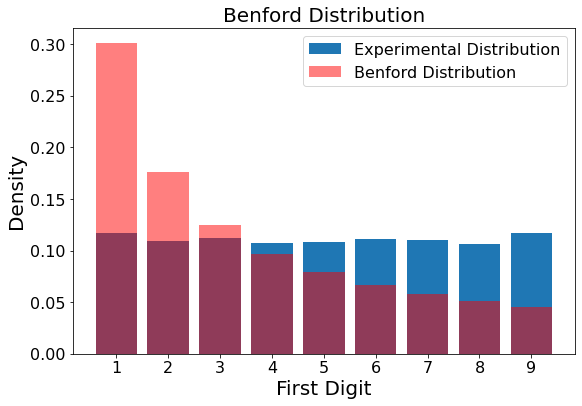

In [7]:
showBenford(simulateBenford(samples=10000,oom=3,ulresets=0))

Interestingly, resetting the upper limit once before sample selection doesn't produce the Benford distribution either. However, we can see that we are moving in the right direction. 

### Figure 3

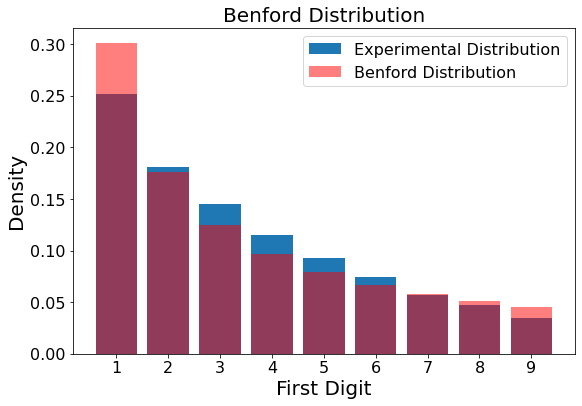

In [8]:
showBenford(simulateBenford(samples=10000,oom=3,ulresets=1))

Resetting the upper limit twice before sample selection produces a distribution that at least visually, is closer to the true Benford distribution, as demonstrated below. Indeed, the more times we reset the upper limit before selecting a sample, the better our experimental data approximate the true Benford distribution.

### Figure 4

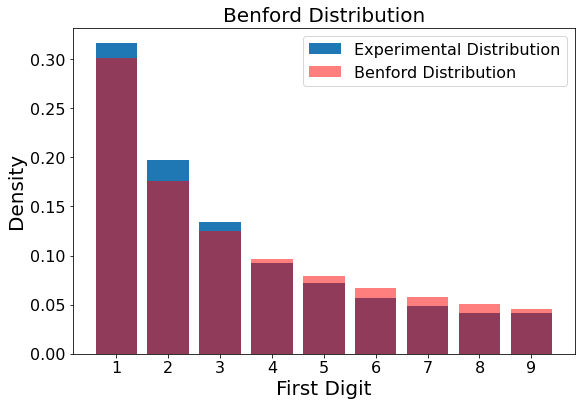

In [6]:
showBenford(simulateBenford(samples=10000,oom=3,ulresets=2))

### Chi-Square Goodness of Fit Test

It is one thing to say that two distributions look similar and quite another to statistically prove that they are the same assuming a certain significance level. In this section we will determine the parameters to our simulation that yield statistically valid Benford distributions. To achieve this, we will use Chi-Square goodness of fit testing and a significance level of $\alpha$ =  0.05. So, for example, in the most recent example we collected 10,000 random samples between 1-1000 after resetting the upper limit two times. We will proceed with Chi-Square testing of these parameters. 

Because this is a Monte Carlo simulation, it makes sense to repeat our testing a number of times to make sure we are getting a reliable Chi-Square statistic and p-value. Let's measure the goodness of fit results for 1,000 Monte Carlo simulations, each with 10,000 sampling events after twice resetting the upper limit on a dataset with an original size of three orders of magnitude.

In [10]:
def n_simulations(n_sims, samples,oom,ulresets, output = True):
    chi2, pval = np.zeros(n_sims), np.zeros(n_sims)
    for i in range(0, n_sims):
        chi2[i],pval[i] = stats.chisquare(simulateBenford(samples,oom,ulresets)*samples, Benford*samples)
    if output:
        print(f"Chi2 statistic: {np.mean(chi2)} ± {np.std(chi2)}\np-value       : {np.mean(pval)} ± {np.std(pval)}")
    else:
        return pval, chi2

### 10,000 Samples

In [11]:
n_simulations(n_sims = 1000, samples = 10000, oom = 3, ulresets = 2)

Chi2 statistic: 60.43986497677765 ± 14.165830746019463
p-value       : 5.778130420535235e-06 ± 5.368245122757202e-05


Clearly, based on our p-value, our experimental distribution in Figure 4 is not statistically similar to the Benford distribution and we reject the null hypothesis. To improve our statistical results, we have two options. We can either decrease the number of sampling events (which is also beneficial because it reduces the time complexity of the simulation) or we can increase the order of magnitude of the original dataset 
First, we will decrease the number of sampling events, in this case from 10,000 to 5,000 and then down to 1,000.

### 5,000 Samples

In [12]:
n_simulations(n_sims = 1000, samples = 5000, oom = 3, ulresets = 2)

Chi2 statistic: 34.51209419876641 ± 10.486028790325573
p-value       : 0.004319027018822002 ± 0.021141311647307415


### 1,000 Samples

In [73]:
pvals1k, chisq1k = n_simulations(n_sims = 1000, samples = 1000, oom = 3, ulresets = 2, output = False)
print(f"Chi-Squared: {np.mean(chisq1k)} ± {np.std(chisq1k)}\np-value    : {np.mean(pvals1k)} ± {np.std(pvals1k)}")

Chi-Squared: 13.123987245023521 ± 5.857009286317922
p-value    : 0.2273694973135859 ± 0.23332735022404547


With one thousand simulations of a Monte Carlo experiment with 1,000 samples (taken after two upper limit resets from an original dataset size of 1,000) we can finally accept the null hypothesis that these simulation parameters produce a true Benford distribution. However, if we look at the standard deviation of the p-values, we can see that these parameters don't reliably produce the Benford distribution. In other words, it is only *on average* that these parameters statistically reproduce the Benford distribution. If we visualize the distribution of p-values, we can see that these parameters are not sufficient. The distribution of p-values should be uniform. We have more work to do. 

In [74]:
def pval_graph(data):
    plt.figure(figsize=(9,6))
    plt.hist(data)
    plt.xticks(size=16)
    plt.xlabel("p-value",size=20)
    plt.yticks(size=16)
    plt.ylabel("Occurrences",size=20)
    plt.show()

### Figure 5

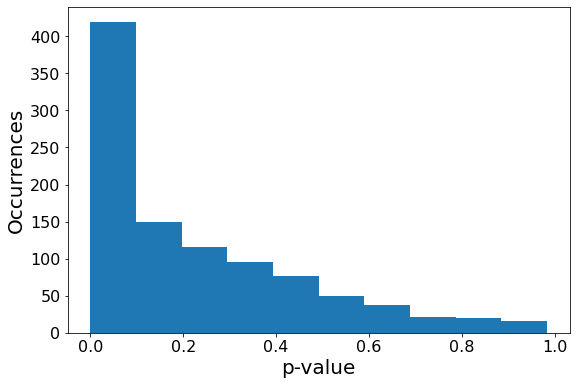

In [75]:
pval_graph(pvals1k)

How can we improve upon these results if we don't want to increase the time complexity of the simulation? Under this constraint, our only option is to adjust the order of magnitude of our original dataset and the number of times we reset the upper limit before sampling. That is, we adjust the *oom* and *ulresets* parameters of the simulateBenford() function. To investigate how these two parameters interact with one another to influence the results, we can survey a number combinations. Note that the order of magnitude cannot be 0 initially because then we would just be sampling the number "1" over and over. Similarly, as mentioned above, the upper limit should be reset 1 or more times. The following survey of parameter combinations is time intensive, yet illustrative. We are searching for combinations that yield average p-values near or equal to 0.5, indivative of a uniform distribution of p-values. 

In [68]:
pval_matrix = np.zeros((10,10))
for oom_num in range(1,11):
    for ulresets_num in range(1,11):
        pvalues, chi = n_simulations(n_sims=1000, samples=1000, oom=oom_num, ulresets=ulresets_num, output=False)
        pval_matrix[oom_num-1,ulresets_num-1] = np.mean(pvalues)
        # Quick and dirty progress bar 
        if oom_num*ulresets_num == 1:
            print("0" + " "*23 + "25" + " "*23 + "50" + " "*23 + "75" + " "*21 + "100")
        print(".", end="")

0                       25                       50                       75                     100
....................................................................................................

Now, we create a visualization showing the mean p-value for every combination for the oom parameter and the ulresets parameter where each parameter can take a value from 1-10. 1000 simulations are used with 1000 samples selected in each simulation. 

### Figure 6

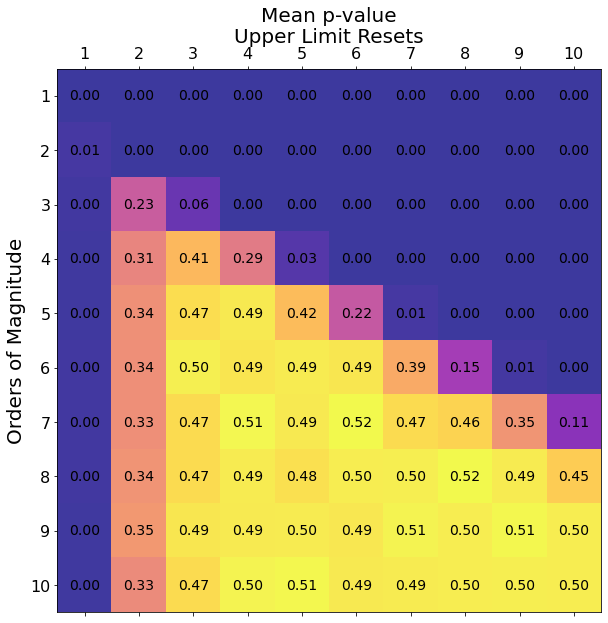

In [69]:
data = np.array(pval_matrix)
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(data, cmap='plasma',alpha = 0.8)
for (i, j), z in np.ndenumerate(data):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',size = 14) #### CHECK THE ORDERING HERE FOR I,J
ax.set_xlabel("Upper Limit Resets",size=20)    
ax.xaxis.set_label_position('top')
ax.set_xticks(ticks = np.arange(0,10)) 
ax.set_xticklabels(labels = np.arange(1,11),fontsize=16)
ax.set_ylabel("Orders of Magnitude",size=20)
ax.set_yticks(ticks = np.arange(0,10))
ax.set_yticklabels(labels = np.arange(1,11),fontsize=16)
plt.title("Mean p-value", size = 20)
plt.show()

This visualization shows that there are many combinations of the oom and ulresets parameters that will yield a proper Benford distribution. At low values for the oom parameter, the highest average p-value in each row is achieved where the ulresets is equal to the oom parameter minus one. At higher values for the oom parameter, a notable trend is that the ulresets parameter should not exceed the oom parameter as this leads to a rapidly decreasing average p-value. Because the oom = ulresets+1 combination works at low oom values and stays valid at high oom values as well, this approach to parameterization will be used. 

We will use 10 orders of magnitude with 9 upper limit resets. We try these parameters with 1000 simulations and 1000 samples, as above, to see if we obtain a uniform distribution of p-values as expected.

In [70]:
pvals, chisqds = n_simulations(n_sims = 1000, samples = 1000, oom = 10, ulresets = 9, output = False)
print(f"Chi2 statistic: {np.mean(chisqds)} ± {np.std(chisqds)}\np-value       : {np.mean(pvals)} ± {np.std(pvalues)}")
print(f"Standard Error: {np.std(pvals)/np.sqrt(pvals.size)}")

Chi2 statistic: 7.997041606769678 ± 4.094764538766474
p-value       : 0.5023664699684578 ± 0.2965934452235761
Standard Error: 0.009305814823535076


### Figure 7

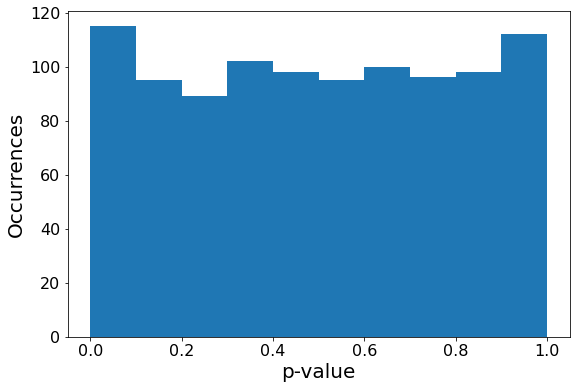

In [71]:
pval_graph(pvals)

As expected, a uniform distribution for our mean p-values. These parameters will reliably produce a statistically valid Benford distribution, shown below. 

### Figure 8

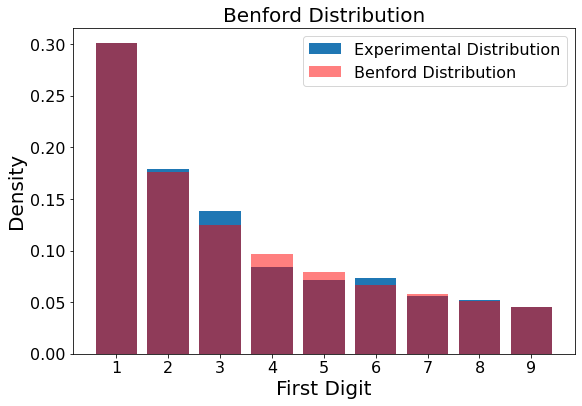

In [33]:
showBenford(simulateBenford(samples=1000,oom=10,ulresets=9))

Still, although statistically valid, the distribution is visually unsatisfactory. We would like to see a closer match with the true Benford distribution. For this, we crank our sample number higher. Let's try 100,000. 

### Figure 9

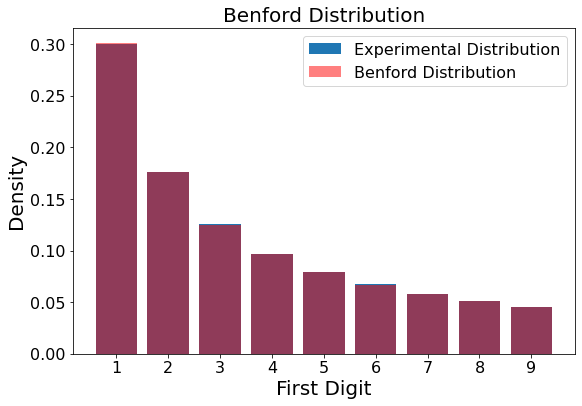

In [51]:
showBenford(simulateBenford(samples=100000,oom=10,ulresets=9))

Much better. One last computationally intensive run of simulations to ensure that the mean p-values are still uniformly distributed for 100,000 samples. Standard error on the mean can also be calculated to check that the calculated mean p-value is within one standard deviation of 0.50.

In [52]:
pvals100k, chi2_100k = n_simulations(n_sims = 1000, samples = 100000, oom = 10, ulresets = 9, output = False)

In [66]:
print(f"Mean p-value  : {np.mean(pvals100k)} ± {np.std(pvals100k)}")
print(f"Standard Error: {np.std(pvals100k)/np.sqrt(pvals100k.size)}")

Mean p-value  : 0.5026501465503054 ± 0.2887606756904799
Standard Error: 0.00913141433871131


### Figure 10

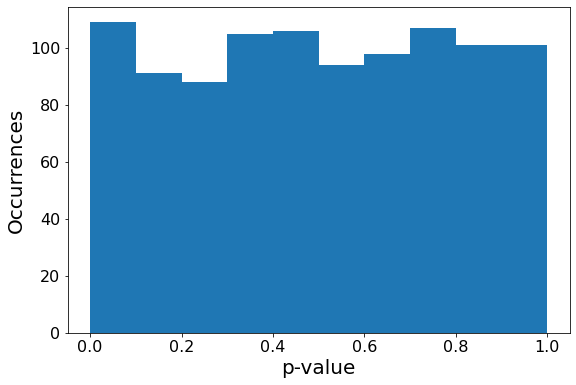

In [67]:
pval_graph(pvals100k)

Done and dusted. Thanks for reading!